# Prosper Loan Data - Default Analysis

### Table Of Contents

* [Introduction](#intro)
* [Exploring the data: categorical information](#explore1)
* [Exploring the data: credit scores](#explore2)
* [Exploring the data: financial information](#explore3)
* [Exploring the data: credit history](#explore4)
* [Exploring the data: loan characteristics](#explore5)

### Introduction <a class="anchor" id="intro"></a>

Here we will do some summary exploaration before working on prediction.

The original data can be found here: https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv. A variable dictionary concisely explaining the data can be found here: https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit?usp=sharing.


In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /Users/sujee/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/var/folders/lp/qm_skljd2hl4xtps5vw0tdgm0000gn/T/tmp2vd7eg43
	some_property=some_value
Spark UI running on port 4040


In [2]:
#Imports

#Data analysis and math
import math
import time
import numpy as np
import pandas as pd
from scipy import stats as st

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (15, 7.5)})

In [3]:
%%time
t1 = time.perf_counter()
data = spark.read.csv("/data/prosper-loan/prosper-loan-data.csv.gz",\
                               header=True, inferSchema=True)
t2 = time.perf_counter()
print("read {:,} records in {:,.2f} ms".format(data.count(), (t2-t1)*1000))

read 49,724 records in 4,266.07 ms
CPU times: user 3.2 ms, sys: 1.89 ms, total: 5.1 ms
Wall time: 4.82 s


In [4]:
data.printSchema()
data.show()

root
 |-- Term: integer (nullable = true)
 |-- LoanStatus: integer (nullable = true)
 |-- BorrowerRate: double (nullable = true)
 |-- ProsperRating (numeric): double (nullable = true)
 |-- ProsperScore: double (nullable = true)
 |-- ListingCategory: string (nullable = true)
 |-- BorrowerState: string (nullable = true)
 |-- EmploymentStatus: string (nullable = true)
 |-- EmploymentStatusDuration: double (nullable = true)
 |-- IsBorrowerHomeowner: boolean (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- CurrentCreditLines: double (nullable = true)
 |-- OpenCreditLines: double (nullable = true)
 |-- TotalCreditLinespast7years: double (nullable = true)
 |-- OpenRevolvingAccounts: integer (nullable = true)
 |-- OpenRevolvingMonthlyPayment: double (nullable = true)
 |-- InquiriesLast6Months: double (nullable = true)
 |-- TotalInquiries: double (nullable = true)
 |-- CurrentDelinquencies: double (nullable = true)
 |-- AmountDelinquent: double (nullable = true)
 |-- Delinquenc

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1)

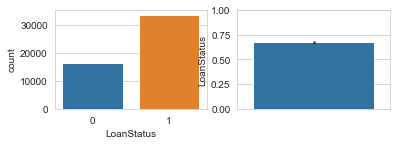

In [5]:
fig = plt.figure()

ax1 = fig.add_subplot(221)

loanStatusdf = data.select('LoanStatus', 'BorrowerState', 'ListingCategory').toPandas()

sns.countplot(loanStatusdf['LoanStatus'])

ax2 = fig.add_subplot(222)
sns.barplot(y=loanStatusdf['LoanStatus']).set_ylim([0,1])

In [6]:
loanStatusdf["LoanStatus"].mean(), 1 - loanStatusdf["LoanStatus"].mean()

(0.6743222588689567, 0.3256777411310433)

So, in the historical data as a whole, 67.43% of loans are completed. 32.57% of loans "defaulted". (During analysis, one should always bear in mind that default as we've defined it includes charge-offs, cancellations, and even any current loans with late payments. It might be more constructive to think of the loans labelled with a 0 as "bad" loans rather than outright "defaults").

Let's take a look at our new historical dataframe and then start exploring variables' relationship with default, starting with some potentially useful categorical information.

In [7]:
loanStatusdf.describe()

,LoanStatus
count,49724.000000
mean,0.674322
std,0.468632
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


### Exploring the data: categorical information <a class="anchor" id="explore1"></a>

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


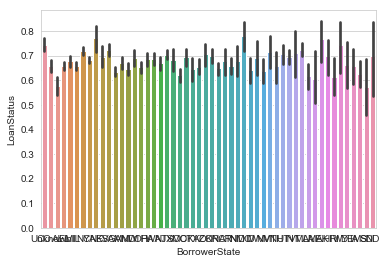

In [8]:
sns.barplot(x="BorrowerState", y="LoanStatus", data=loanStatusdf)
plt.show()

In [9]:
al, dc = loanStatusdf[loanStatusdf["BorrowerState"] == "AL"], loanStatusdf[loanStatusdf["BorrowerState"] == "DC"]

1 - al["LoanStatus"].mean(), 1 - dc["LoanStatus"].mean()

(0.42205323193916355, 0.22043010752688175)

There seems to be some variation. Loans to people in Alabama defaulted 42.21% of the time, whereas loans to people in Washington D.C. only defaulted 22.04% of the time. Cool! We'll have to try to make this categorical information useable in our classifier--perhaps with dummy variables.

Let's take a look at another categorical variable: ListingCategory.

First though, it's a bit annoying having to constantly refer to our variable definitions to understand the listing category, so before we interpret this, let's change our numeric values to the actual category names. This will also be useful, because the numeric values imply some sort of false ordinality, and we should really handle this like a categorical variable.

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


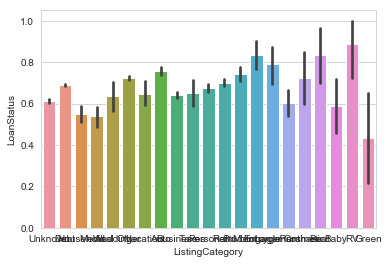

In [10]:
sns.barplot(x="ListingCategory", y="LoanStatus", data=loanStatusdf)
plt.show()

In [11]:
rv, green = loanStatusdf[loanStatusdf["ListingCategory"] == "RV"], loanStatusdf[loanStatusdf["ListingCategory"] == "Green"]

1 - rv["LoanStatus"].mean(), 1 - green["LoanStatus"].mean()

(0.11111111111111116, 0.5652173913043479)

So, once again, certain types of loans seem to be outperforming others, with RV loans only defaulting 11.11% of the time, and green loans defaulting 56.52% of the time. Other frequent defaulters are loans for household expenses and for medical and dental work, while people seem to completely pay boat and motorcycle loans quite frequently. 

Let's examine some credit scoring metrics.

### Exploring the data: credit scores <a class="anchor" id="explore2"></a>

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


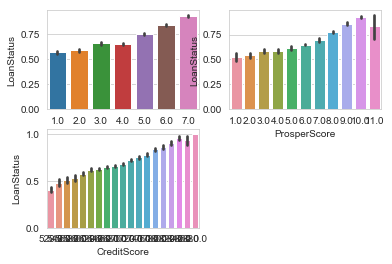

In [12]:
creditscoredf = data.select('LoanStatus', 'ProsperRating (numeric)', 'ProsperScore', 'CreditScore').toPandas()


fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="ProsperRating (numeric)", y="LoanStatus", data=creditscoredf)

ax2 = fig.add_subplot(222)
sns.barplot(x="ProsperScore", y="LoanStatus", data=creditscoredf)

ax3 = fig.add_subplot(223)
sns.barplot(x="CreditScore", y="LoanStatus", data=creditscoredf)


Both the Prosper scores and the credit scores seem to be doing a good job of predicting default, with higher ratings defaulting less frequently. Interestingly, the loans with the highest ProsperScores (11) default more frequently than loans rated at a 9 or a 10, and there is a high degree of variance in default rate for those highly rated loans.


Let's visualize some financial variables.

### Exploring the data: financial information <a class="anchor" id="explore3"></a>

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 400)

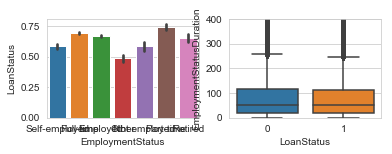

In [13]:
fig = plt.figure()

creditscoredf = data.select('LoanStatus', 'EmploymentStatus', 'EmploymentStatusDuration', 
                                     'StatedMonthlyIncome', 'DebtToIncomeRatio', 'AvailableBankcardCredit',
                                     'BankcardUtilization', 'IsBorrowerHomeowner').toPandas()


ax1 = fig.add_subplot(221)
sns.barplot(x="EmploymentStatus", y="LoanStatus", data=creditscoredf)

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="EmploymentStatusDuration", data=creditscoredf).set_ylim([0,400])

There doesn't seem to be a relationship between EmploymentStatusDuration and loan default. We'll take a look at the correlation in a moment. EmploymentStatus does, however, seem to have a relationship with default. Interestingly, part-time workers defaulted less often than full-time workers. People who listed their employment status as "Other" defaulted even more often than those who weren't employed at all.

In [14]:
x = creditscoredf["EmploymentStatusDuration"]
y = creditscoredf["LoanStatus"]

r, p = st.pearsonr(x, y)

print("The correlation between employment status duration and loan default is {}, with a p-value of {}".format(r, p))

The correlation between employment status duration and loan default is -0.0059057028589972775, with a p-value of 0.1878775422194832


The very weak correlation between employment status duration and loan default, as well as the lack of a statistically significant p-value, lead me to believe that we can safely drop this variable from our dataset.

Let's plot some income metrics and then some indicators of credit availability.

(0, 0.8)

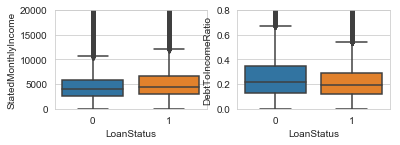

In [15]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="StatedMonthlyIncome", data=creditscoredf).set_ylim([0,20000])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="DebtToIncomeRatio", data=creditscoredf).set_ylim([0,0.8])

Both monthly income and debt : income seem to have a relationship with default. People with higher stated incomes defaulted less often than those with lower incomes, regardless of the size of the loan. And as is intuitive, loans are more likely to default if the ratio of debt to income is higher. 

(0, 2.5)

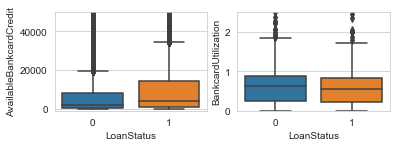

In [16]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="AvailableBankcardCredit", data=creditscoredf).set_ylim([-1000, 50000])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="BankcardUtilization", data=creditscoredf).set_ylim([0,2.5])

We find a similar picture to income, wherein the availability of bankcard credit coincides with completed loans, and the lower the proportion of bankcard utilization, the lower the likelihood of default.

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1)

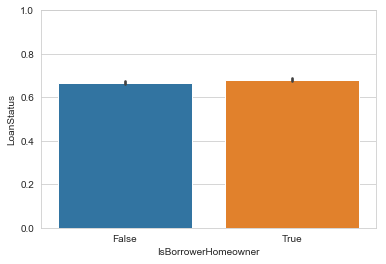

In [17]:
sns.barplot(x="IsBorrowerHomeowner", y="LoanStatus", data=creditscoredf).set_ylim([0,1])

It seems homeowners default very slightly less often than renters.

Next let's look at some credit history variables.

### Exploring the data: credit history <a class="anchor" id="explore4"></a>

(0, 20)

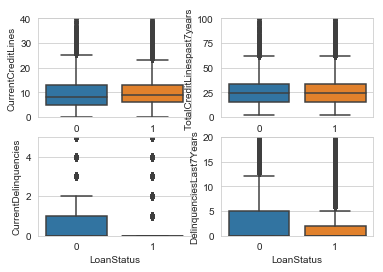

In [18]:

credithistorydf = data.select('LoanStatus', 'CurrentCreditLines', 'TotalCreditLinespast7years', 
                                     'CurrentDelinquencies', 'DelinquenciesLast7Years', 'LoanOriginalAmount',
                                     'Term', 'BorrowerRate', 'CreditScore').toPandas()



fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="CurrentCreditLines", data=credithistorydf).set_ylim([0,40])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="TotalCreditLinespast7years", data=credithistorydf).set_ylim([0,100])

ax3 = fig.add_subplot(223)
sns.boxplot(x="LoanStatus", y="CurrentDelinquencies", data=credithistorydf).set_ylim([0,5])

ax4 = fig.add_subplot(224)
sns.boxplot(x="LoanStatus", y="DelinquenciesLast7Years", data=credithistorydf).set_ylim([0,20])

Number of credit lines doesn't seem to have a particularly significant relationship with default, but delinquencies do. Among loans that were completed, it is very rare for the debtor to have any current delinquencies. Likewise, a history of delinquency seems to indicate a propensity for default. Let's take a look at those correlations.

In [19]:
delinquency = ["CurrentDelinquencies", "DelinquenciesLast7Years"]
y = credithistorydf["LoanStatus"]

for var in delinquency:
    x = credithistorydf[var]
    r, p = st.pearsonr(x, y)

    print("The correlation between {} and loan default is {}, with a p-value of {}".format(var, r, p))

The correlation between CurrentDelinquencies and loan default is -0.12107063477741749, with a p-value of 1.0845242651745478e-161
The correlation between DelinquenciesLast7Years and loan default is -0.06975250066577986, with a p-value of 1.1176410321268129e-54


Both current and historical delinquency correlate significantly (p < 0.05) with loan status. Current delinquencies in particular should be a very strong feature for us.

### Exploring the data: loan characteristics <a class="anchor" id="explore5"></a>

To wrap up, let's take a look at the characteristics of the loans themselves.

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(10, 60)

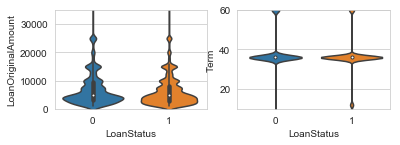

In [20]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.violinplot(x="LoanStatus", y="LoanOriginalAmount", data=credithistorydf).set_ylim([0,35000])

ax2 = fig.add_subplot(222)
sns.violinplot(x="LoanStatus", y="Term", data=credithistorydf).set_ylim([10, 60])

The distribution of the loan amount seems to be consistent between both classes. 

In [21]:
credithistorydf["Term"].value_counts()

36    43754
60     4418
12     1552
Name: Term, dtype: int64

Prosper loans can only have a term of 12, 36, or 60 months. By far the most common is the term of 3 years. Term probably won't be of much use to us to classify our loans either then. Let's wrap up by examining interest rates.

/Users/sujee/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


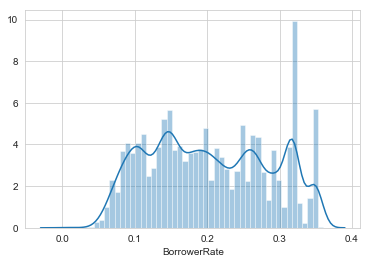

In [22]:
sns.distplot(credithistorydf["BorrowerRate"])

In [23]:
credithistorydf["BorrowerRate"].describe()

count    49724.000000
mean         0.203470
std          0.082468
min          0.000000
25%          0.136400
50%          0.199000
75%          0.270000
max          0.360000
Name: BorrowerRate, dtype: float64

The mean interest rate (without any fees) for all Prosper loans is a fairly substantial 20.35%. From my experience and a quick google, that is roughly equivalent to that of a credit card. The standard deviation is 8.25% however, meaning that the lowest 25% of borrowers are paying a much more reasonable 13.64%, but that the top 25% of borrowers are paying 27.00% and more, before fees!

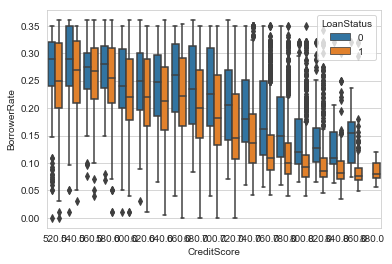

CPU times: user 512 ms, sys: 9.89 ms, total: 522 ms
Wall time: 535 ms


In [24]:
%%time
sns.boxplot(x="CreditScore", y='BorrowerRate', hue='LoanStatus', data=credithistorydf)
plt.show()

Generally, loans that default have a higher interest rate than loans that are paid completely, even when controlling for credit score. That makes sense, but it's still really cool to see in the chart above.

Right, so we've had the chance to take a look at some variables and their relationship to default. It seems there are a lot of good potential features available to us, although some of them are categorical and will need some work before we can use them in all of our classifiers.

In [25]:
state_defaults = loanStatusdf.groupby("BorrowerState")["LoanStatus"].mean()

vlow_risk = sorted(state_defaults)[51]
low_risk = sorted(state_defaults)[40]
mid_risk = sorted(state_defaults)[29]
high_risk = sorted(state_defaults)[19]
vhigh_risk = sorted(state_defaults)[9]

new_geography = {}

for state in state_defaults.index:
    if high_risk > state_defaults[state]:
        v = "StateVeryHighRisk"
    elif mid_risk > state_defaults[state] >= high_risk:
        v = "StateHighRisk"
    elif low_risk > state_defaults[state] >= mid_risk:
        v = "StateMidRisk"
    elif vlow_risk > state_defaults[state] >= low_risk:
        v = "StateLowRisk"
    else:
        v = "StateVeryLowRisk"
    new_geography[state] = v

                               
loanStatusdf["BorrowerStateRisk"] = loanStatusdf["BorrowerState"]
loanStatusdf.replace(to_replace={"BorrowerStateRisk": new_geography}, inplace=True)

